<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/tvgwfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created: October 25, 2024

Purpose: view TV groundwater data from Modflow6 and crop to Mason Drainage

Output units from the TVGWFM are in cubic feet per day

## Process groundwater data from TVGWFM and convert to csv

In [1]:
!pip install flopy
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import box, Polygon
import matplotlib.gridspec as gridspec
import calendar

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.7 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
# Load the dataset (obtained from executing modflow) and access the data

model_dir = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/groundwater/model'

# load the model
sim = flopy.mf6.MFSimulation.load(
    sim_ws=model_dir,
    verbosity_level=0,
)

ml = sim.get_model("mf6-tv_hist")

bud = ml.output.budget()
bud_array_list = bud.get_data(idx=0, full3D=True)

bud.get_unique_record_names()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[b'          STO-SS',
 b'    FLOW-JA-FACE',
 b'      DATA-SPDIS',
 b'             WEL',
 b'             DRN',
 b'             RIV',
 b'             GHB']

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


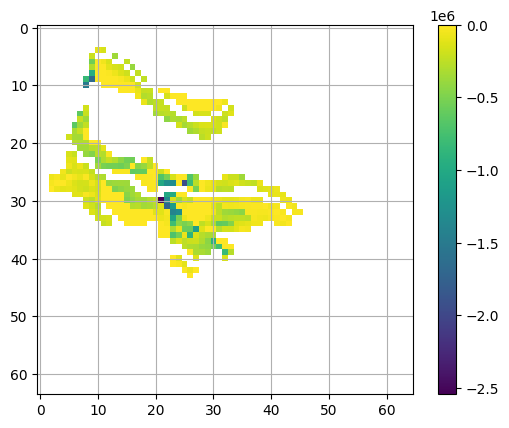

In [4]:
# View the raw data

# get a list of numpy masked arrays, where each stress period (and time-step)
# is an item in the list
drn_out_arr = bud.get_data(text='DRN', full3D=True)
# get a single masked array out of the list (in this case the 0th stress period)
drn_ma_i = drn_out_arr[0]
# get a regular numpy array by filling the masked cells with nan
drn_arr_i = drn_ma_i.filled(np.nan)
# get the top layer values
drn_arr_lay1 = drn_arr_i[0, :, :]
# plot
plt.imshow(drn_arr_lay1)
plt.colorbar()
plt.grid()

In [ ]:
drn_arr_i.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(6, 64, 65)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


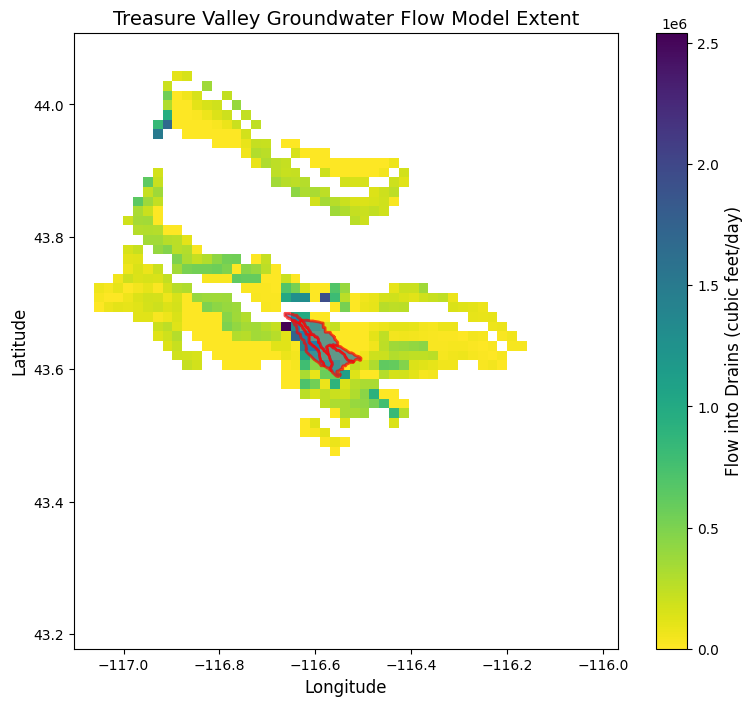

In [36]:
# Load the reach shapefile
reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')

# Bounding box of the model from USGS
min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083

# Original extent
extent = [min_lon, max_lon, min_lat, max_lat]

# Adjust x-axis limits to remove excess white space on the right
right_crop_factor = 0.15  # Adjust this value to remove more/less white space
adjusted_max_lon = max_lon - (max_lon - min_lon) * right_crop_factor  # Crop right side

# Plot the model output with adjusted limits
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(drn_arr_lay1, cmap='viridis_r', extent=extent, origin='upper')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Flow into Drains (cubic feet/day)', fontsize=12)

# Overlay the reach shapefile
reach_gdf.plot(ax=ax, edgecolor='red', linewidth=2, alpha=0.7)

# Manually adjust x-axis limits to remove excess white space on the right
ax.set_xlim(min_lon, adjusted_max_lon)
ax.set_ylim(min_lat, max_lat)  # Keep y-axis unchanged to maintain Mason alignment

# Customize plot
plt.title('Treasure Valley Groundwater Flow Model Extent', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


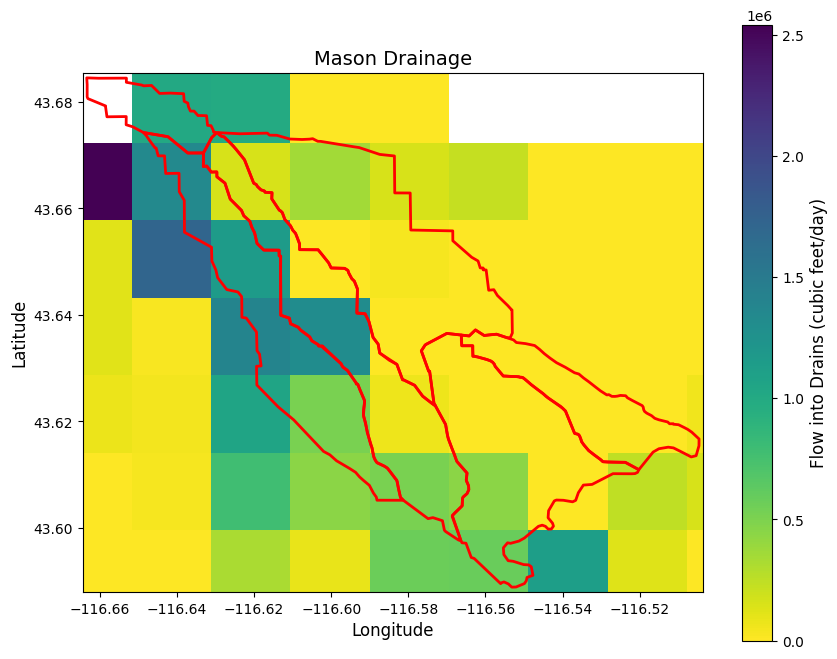

In [26]:
# Visualize the Overlap between Mason Drainage and the TVGWF
# Mason Creek only

reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')

if reach_gdf.crs != 'EPSG:4326':
    reach_gdf = reach_gdf.to_crs('EPSG:4326')

# Use the bounding box of the reach shapefile with a small buffer for tighter cropping
minx, miny, maxx, maxy = reach_gdf.total_bounds
buffer = 0.001  # Tight buffer to crop closer to the fields
cropped_extent = [minx - buffer, maxx + buffer, miny - buffer, maxy + buffer]

# Invert the grid data (convert negatives to positives because gw data was showing this as a loss)
drn_arr_lay1 = np.abs(drn_arr_lay1)

# Plot the model output with a corrected extent
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(drn_arr_lay1, cmap='viridis_r', extent=[-117.103530233726, -115.768691366538, 43.1778883119514, 44.1083], origin='upper')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Flow into Drains (cubic feet/day)', fontsize=12)

# Overlay the reach shapefile with transparency and a red outline
reach_gdf.plot(ax=ax, edgecolor='red', linewidth=2, facecolor='none')

ax.set_xlim(cropped_extent[0], cropped_extent[1])
ax.set_ylim(cropped_extent[2], cropped_extent[3])
plt.title('Mason Drainage', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

In [ ]:
# ---------------------------- #
# GW contribution to each reach
# ---------------------------- #


# units: cubic feet per day

reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')

# Ensure CRS is defined
if reach_gdf.crs is None:
    reach_gdf.set_crs("EPSG:4326", inplace=True)

# Function to process each stress period
def process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf):
    # Extract the masked array for the current stress period
    drn_ma_i = drn_out_arr[stress_period]
    drn_arr_i = drn_ma_i.filled(np.nan)
    drn_arr_lay1 = drn_arr_i[0, :, :]  # Top layer values

    # Grid dimensions
    nrows, ncols = drn_arr_lay1.shape
    cell_width = (max_lon - min_lon) / ncols
    cell_height = (max_lat - min_lat) / nrows

    # Create grid of polygons and values
    polygons = []
    values = []
    for i in range(nrows):
        for j in range(ncols):
            x1 = min_lon + j * cell_width
            y1 = max_lat - i * cell_height
            x2 = x1 + cell_width
            y2 = y1 - cell_height
            polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
            values.append(drn_arr_lay1[i, j])
    grid_gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs="EPSG:4326")

    # Ensure CRS match
    if grid_gdf.crs != reach_gdf.crs:
        reach_gdf = reach_gdf.to_crs(grid_gdf.crs)

    # Initialize results for this stress period
    stress_results = []

    # Process each reach
    for _, reach_row in reach_gdf.iterrows():
        reach_geom = reach_row.geometry
        reach_name = reach_row['Reach']  # Replace with actual column name

        # Calculate intersection of the reach with the grid cells
        grid_gdf['intersection'] = grid_gdf.geometry.intersection(reach_geom)
        grid_gdf['intersection_area'] = grid_gdf['intersection'].area
        grid_gdf['cell_area'] = grid_gdf.geometry.area
        grid_gdf['weight'] = grid_gdf['intersection_area'] / grid_gdf['cell_area']
        grid_gdf['weighted_value'] = grid_gdf['value'] * grid_gdf['weight']

        # Sum the weighted values for the reach
        reach_sum = grid_gdf['weighted_value'].sum()

        # Store the result
        stress_results.append({'Stress Period': stress_period, 'Reach': reach_name, 'Flow (cfperday)': reach_sum})

    return stress_results

# Define bounding box
min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083

# Initialize final results
all_results = []

# Loop through stress periods
for stress_period in range(300, 361):
    stress_results = process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf)
    all_results.extend(stress_results)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_cfday.csv', index=False)
# Display or save results
print(results_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-37-19a97b837f88>:53: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersection_area'] = grid_gdf['intersection'].area
<ipython-input-37-19a97b837f88>:54: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['cell_area'] = grid_gdf.geometry.area
<ipython-input-37-19a97b837f88>:53: UserWarning: Geometry is in a geographic CRS. Results from 'ar

     Stress Period          Reach  Flow (cfperday)
0              300    Noble Drain    -1.001167e+06
1              300   Purdum Reach    -8.182907e+03
2              300  Solomon Reach    -2.008729e+06
3              300        Reach 1    -2.292895e+05
4              300        Reach 2    -2.510811e+05
..             ...            ...              ...
361            360   Purdum Reach    -5.238582e+03
362            360  Solomon Reach    -1.746103e+06
363            360        Reach 1    -1.257237e+05
364            360        Reach 2    -1.963767e+05
365            360        Reach 3    -3.742834e+05

[366 rows x 3 columns]


In [ ]:
# ---------------------------- #
# GW contribution to each reach
# ---------------------------- #

# units: AF/day

def process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf):
    # Extract the masked array for the current stress period
    drn_ma_i = drn_out_arr[stress_period]
    drn_arr_i = drn_ma_i.filled(np.nan)
    drn_arr_lay1 = drn_arr_i[0, :, :]  # Top layer values

    # Grid dimensions
    nrows, ncols = drn_arr_lay1.shape
    cell_width = (max_lon - min_lon) / ncols
    cell_height = (max_lat - min_lat) / nrows

    # Create grid of polygons and values
    polygons = []
    values = []
    for i in range(nrows):
        for j in range(ncols):
            x1 = min_lon + j * cell_width
            y1 = max_lat - i * cell_height
            x2 = x1 + cell_width
            y2 = y1 - cell_height
            polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
            # Convert cfd to acre-feet per month (using 30.4375 days)
            values.append(drn_arr_lay1[i, j] * 30 / 43560)
    grid_gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs="EPSG:4326")

    # Ensure CRS match
    if grid_gdf.crs != reach_gdf.crs:
        reach_gdf = reach_gdf.to_crs(grid_gdf.crs)

    # Initialize results for this stress period
    stress_results = []

    # Process each reach
    for _, reach_row in reach_gdf.iterrows():
        reach_geom = reach_row.geometry
        reach_name = reach_row['Reach']  # Replace with actual column name

        # Calculate intersection of the reach with the grid cells
        grid_gdf['intersection'] = grid_gdf.geometry.intersection(reach_geom)
        grid_gdf['intersection_area'] = grid_gdf['intersection'].area
        grid_gdf['cell_area'] = grid_gdf.geometry.area
        grid_gdf['weight'] = grid_gdf['intersection_area'] / grid_gdf['cell_area']
        grid_gdf['weighted_value'] = grid_gdf['value'] * grid_gdf['weight']

        # Sum the weighted values for the reach
        reach_sum = grid_gdf['weighted_value'].sum()

        # Store the result
        stress_results.append({'Stress Period': stress_period, 'Reach': reach_name, 'Weighted Sum': reach_sum})

    return stress_results

# Define bounding box of Mason
min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083

# Initialize final results
all_results = []

# Loop through stress periods
for stress_period in range(300, 361):
    stress_results = process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf)
    all_results.extend(stress_results)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv', index=False)
# Display or save results
print(results_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-19-b7cb4500d7f6>:46: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersection_area'] = grid_gdf['intersection'].area
<ipython-input-19-b7cb4500d7f6>:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['cell_area'] = grid_gdf.geometry.area
<ipython-input-19-b7cb4500d7f6>:46: UserWarning: Geometry is in a geographic CRS. Results from 'ar

     Stress Period          Reach  Weighted Sum
0              300    Noble Drain   -689.508967
1              300   Purdum Reach     -5.635611
2              300  Solomon Reach  -1383.422271
3              300        Reach 1   -157.912860
4              300        Reach 2   -172.920875
..             ...            ...           ...
361            360   Purdum Reach     -3.607839
362            360  Solomon Reach  -1202.549972
363            360        Reach 1    -86.586571
364            360        Reach 2   -135.245644
365            360        Reach 3   -257.770960

[366 rows x 3 columns]


In [ ]:
# -------------------------------------- #
# Create Dataset for input into WB images
# -------------------------------------- #

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_cfday.csv')

# Define the starting year and the total number of stress periods
start_year = 1986
total_stress_periods = 360

# Generate a sequence of dates starting from January of the starting year
dates = pd.date_range(start=f"{start_year}-01-01", periods=total_stress_periods, freq='MS')

# Create a new DataFrame mapping stress periods to months and years
dates_df = pd.DataFrame({
    'Stress Period': range(1, total_stress_periods + 1),
    'Month': dates.month,
    'Year': dates.year
})

# Merge the new date information into the original DataFrame
result_df = df.merge(dates_df, on='Stress Period')

# Add a new column converting Flow from cf/day to KAF
conversion_factor_kaf = 0.0000229568 * 0.001  # Cubic feet to KAF
result_df['Flow (KAF)'] = result_df['Flow (cfperday)'] * conversion_factor_kaf

result_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/gw_final_kaf.csv', index=False)

## Make images from GW data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


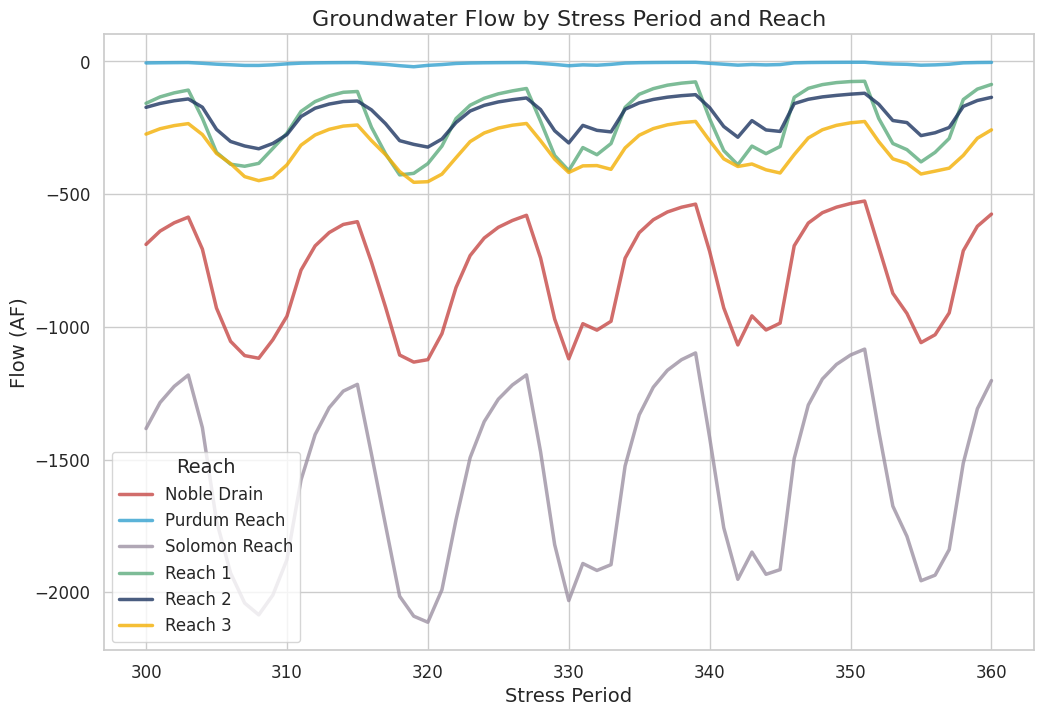

In [ ]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# This plot is from the perspective of the GW (showing GW losses)

results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')

sns.set(style="whitegrid")

# for Reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Drain": "#C64846"
}

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Stress Period',
    y='Weighted Sum',
    hue='Reach',
    palette=reach_palette,
    linewidth=2.5,
    alpha=0.8
)

plt.title('Groundwater Flow by Stress Period and Reach', fontsize=16)
plt.xlabel('Stress Period', fontsize=14)
plt.ylabel('Flow (AF)', fontsize=14)
plt.legend(title='Reach', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


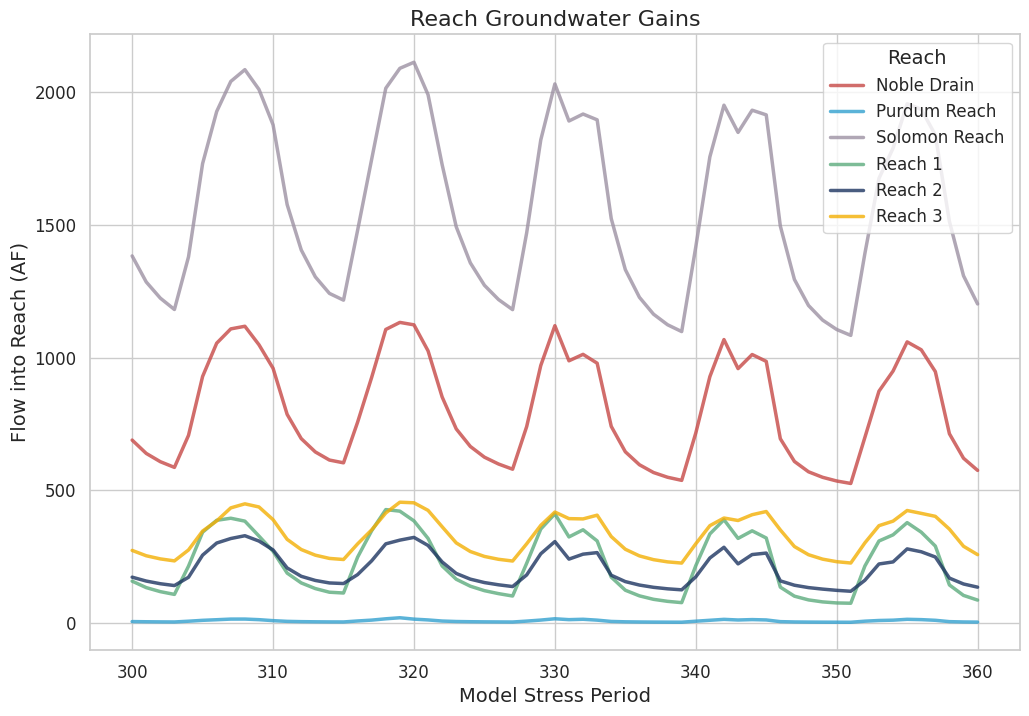

In [ ]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# This plot is from the perspective of the reach (showing reach gains)


results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')

# Take the absolute value of the 'Weighted Sum' column
results_df['Weighted Sum'] = results_df['Weighted Sum'].abs()

# Set up the seaborn style
sns.set(style="whitegrid")

# Define the palette for the reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Drain": "#C64846"
}

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Stress Period',
    y='Weighted Sum',
    hue='Reach',
    palette=reach_palette,
    linewidth=2.5,
    alpha=0.8
)

# Customize the plot
plt.title('Reach Groundwater Gains', fontsize=16)
plt.xlabel('Model Stress Period', fontsize=14)
plt.ylabel('Flow into Reach (AF)', fontsize=14)
plt.legend(title='Reach', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


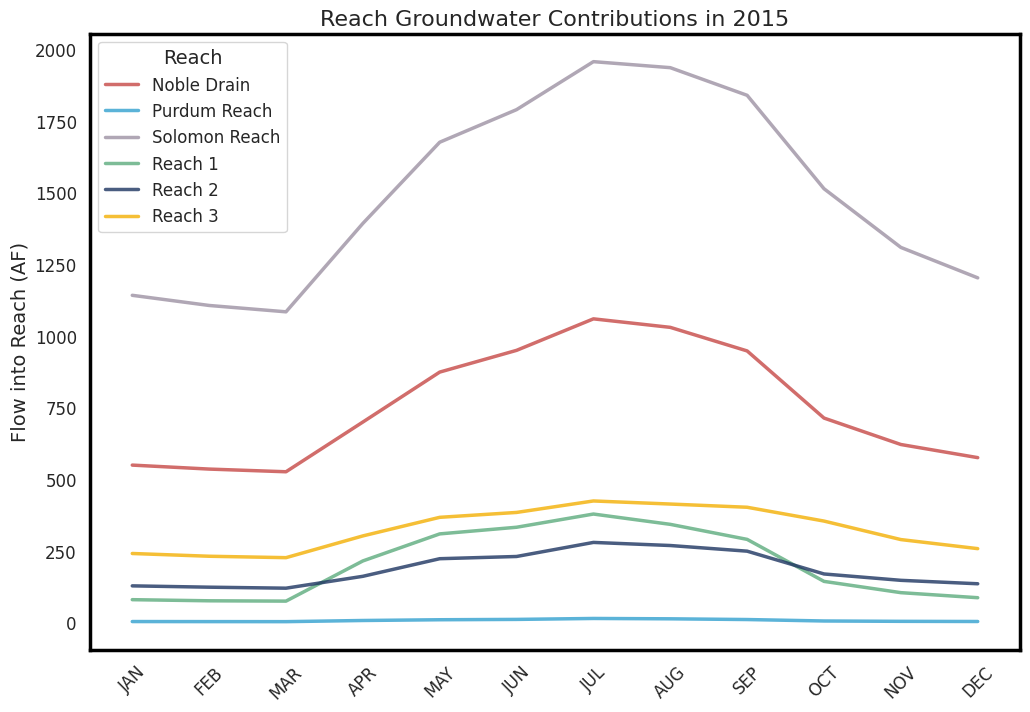

In [ ]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# 2015 data only
#kaf

results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')

# Take the absolute value of the 'Weighted Sum' column to make it from the persective of the reach
results_df['Weighted Sum'] = results_df['Weighted Sum'].abs()

# Filter for stress periods 349 to 360 for the year 2015
results_df = results_df[(results_df['Stress Period'] >= 349) & (results_df['Stress Period'] <= 360)]

# Map stress periods to abbreviated months
month_mapping = {
    349: 'JAN', 350: 'FEB', 351: 'MAR', 352: 'APR', 353: 'MAY', 354: 'JUN',
    355: 'JUL', 356: 'AUG', 357: 'SEP', 358: 'OCT', 359: 'NOV', 360: 'DEC'
}
results_df['Month'] = results_df['Stress Period'].map(month_mapping)

# Set up seaborn style without grid
sns.set_style("white")  # Removes grid lines

# Define the palette for the reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Drain": "#C64846"
}

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Month',
    y='Weighted Sum',
    hue='Reach',
    palette=reach_palette,
    linewidth=2.5,
    alpha=0.8
)

# Customize the plot
plt.title('Reach Groundwater Contributions in 2015', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('Flow into Reach (AF)', fontsize=14)
plt.legend(title='Reach', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Darken the plot outline
ax = plt.gca()  # Get current axis
ax.spines['top'].set_linewidth(2.5)
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth(2.5)
ax.spines['right'].set_color('black')
ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

# Add small ticks next to each axis label
ax.tick_params(axis='x', length=6, width=1.5, direction='out')  # Small ticks on x-axis
ax.tick_params(axis='y', length=6, width=1.5, direction='out')  # Small ticks on y-axis


plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw2015.png', dpi=300, bbox_inches='tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


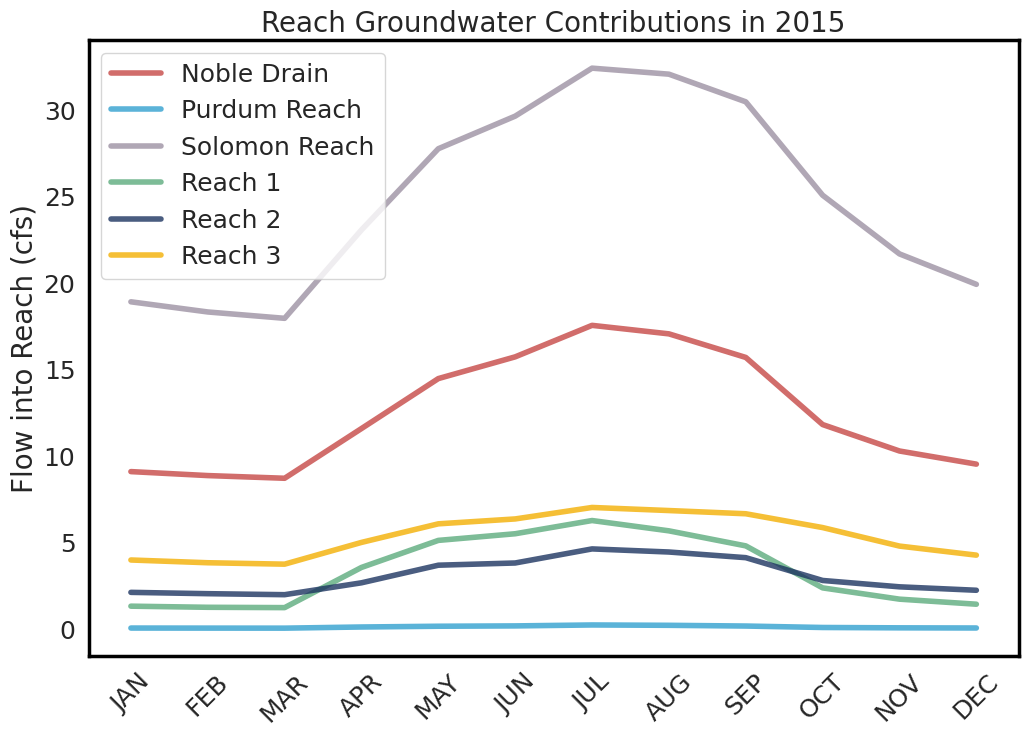

In [ ]:
# -------------------------------- #
# Figure: Reach GW Gains per month
# -------------------------------- #

# 2015 data only
#cfs


results_df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_afpermonth.csv')

# Take the absolute value of the 'Weighted Sum' column to make it from the perspective of the reach
results_df['Weighted Sum'] = results_df['Weighted Sum'].abs()

# Conversion factor: 1 AF/month to cfs
days_in_month = 30.436875  # Average number of days in a month
af_to_cfs_conversion = 43560 / (days_in_month * 24 * 60 * 60)  # 1 AF = 43560 cubic feet
results_df['Weighted Sum (cfs)'] = results_df['Weighted Sum'] * af_to_cfs_conversion

# Filter for stress periods 349 to 360 for the year 2015
results_df = results_df[(results_df['Stress Period'] >= 349) & (results_df['Stress Period'] <= 360)]

# Map stress periods to abbreviated months
month_mapping = {
    349: 'JAN', 350: 'FEB', 351: 'MAR', 352: 'APR', 353: 'MAY', 354: 'JUN',
    355: 'JUL', 356: 'AUG', 357: 'SEP', 358: 'OCT', 359: 'NOV', 360: 'DEC'
}
results_df['Month'] = results_df['Stress Period'].map(month_mapping)

# Set up seaborn style without grid
sns.set_style("white")  # Removes grid lines

# Define the palette for the reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Drain": "#C64846"
}

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=results_df,
    x='Month',
    y='Weighted Sum (cfs)',
    hue='Reach',
    palette=reach_palette,
    linewidth=4.0,  # Increase the linewidth for wider lines
    alpha=0.8
)

# Customize the plot
plt.title('Reach Groundwater Contributions in 2015', fontsize=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Flow into Reach (cfs)', fontsize=20)
plt.legend(title='', fontsize=18, title_fontsize=20)
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)

# Darken the plot outline
ax = plt.gca()  # Get current axis
ax.spines['top'].set_linewidth(2.5)
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth(2.5)
ax.spines['right'].set_color('black')
ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

# Add small ticks next to each axis label
ax.tick_params(axis='x', length=6, width=1.5, direction='out')  # Small ticks on x-axis
ax.tick_params(axis='y', length=6, width=1.5, direction='out')  # Small ticks on y-axis

# Save and display the plot
plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw2015_cfs_widerlines.png', dpi=300, bbox_inches='tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-2-45c3e87c0923>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'ho

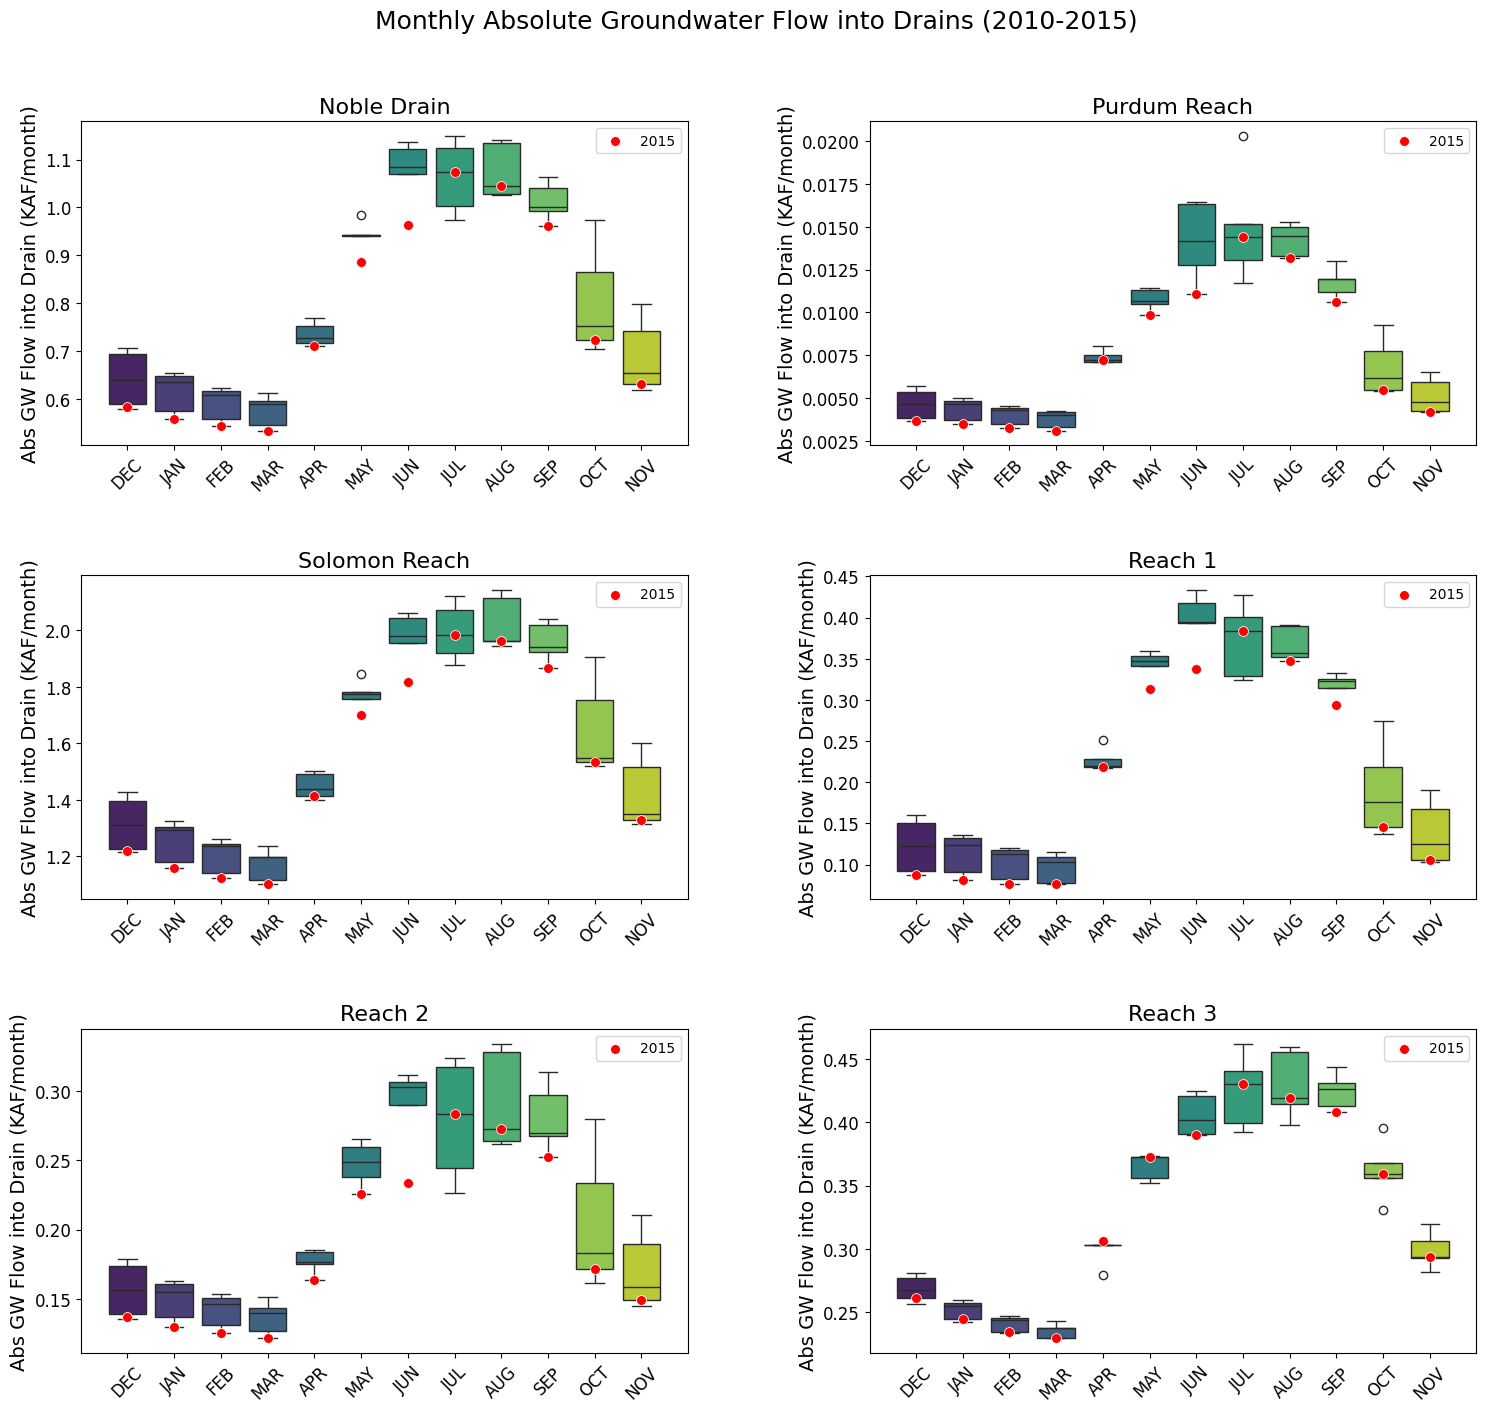

In [ ]:
# -------------------------------- #
# Figure: Boxplot of average gw to reach
# -------------------------------- #

# 2011 to 2015 data

# KAF
df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_cfday.csv')

# Define the starting year and the total number of stress periods
start_year = 1986
total_stress_periods = 360

# Generate a sequence of dates starting from January of the starting year
dates = pd.date_range(start=f"{start_year}-01-01", periods=total_stress_periods, freq='MS')

# Create a new DataFrame mapping stress periods to months and years
dates_df = pd.DataFrame({
    'Stress Period': range(1, total_stress_periods + 1),
    'Month': dates.month,
    'Year': dates.year
})

# Merge the new date information into the original DataFrame
result_df = df.merge(dates_df, on='Stress Period')

# Convert numeric months to abbreviated names (e.g., 1 -> JAN, 12 -> DEC)
result_df['Month'] = result_df['Month'].apply(lambda x: calendar.month_abbr[x].upper())

# Convert Flow from cubic feet per day to KAF per month and take the absolute value
conversion_factor_kaf_month = 0.0000229568 * 0.001 * 30.436875
result_df['Flow (KAF/month)'] = result_df['Flow (cfperday)'] * conversion_factor_kaf_month
result_df['Flow (Abs KAF/month)'] = result_df['Flow (KAF/month)'].abs()

# Filter data for the years 2010 to 2015
filtered_df = result_df[(result_df['Year'] >= 2010) & (result_df['Year'] <= 2015)]

# Get unique reaches
unique_reaches = filtered_df['Reach'].unique()

# Create a grid of subplots to display each reach in a larger layout (2 columns, 3 rows)
fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.3, hspace=0.4)  # Adjust grid size and spacing

# Loop through each reach and create a box plot for absolute monthly flow in a panel
for idx, reach in enumerate(unique_reaches):
    ax = fig.add_subplot(gs[idx])  # Add subplot to the grid
    reach_data = filtered_df[filtered_df['Reach'] == reach]
    reach_data_2015 = reach_data[reach_data['Year'] == 2015]  # Filter data for 2015

    # Create the box plot
    sns.boxplot(
        data=reach_data,
        x='Month',
        y='Flow (Abs KAF/month)',
        palette='viridis',
        ax=ax
    )

    # Overlay 2015 data as red dots
    sns.scatterplot(
        data=reach_data_2015,
        x='Month',
        y='Flow (Abs KAF/month)',
        color='red',
        label='2015',
        s=50,  # Adjust size of the dots
        zorder=5,
        ax=ax
    )

    # Customize the plot
    ax.set_title(f'{reach}', fontsize=16)
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('Abs GW Flow into Drain (KAF/month)', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# Add a common title for the entire figure
fig.suptitle('Monthly Absolute Groundwater Flow into Drains (2010-2015)', fontsize=18, y=0.95)

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-187eda19d9cd>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'ho

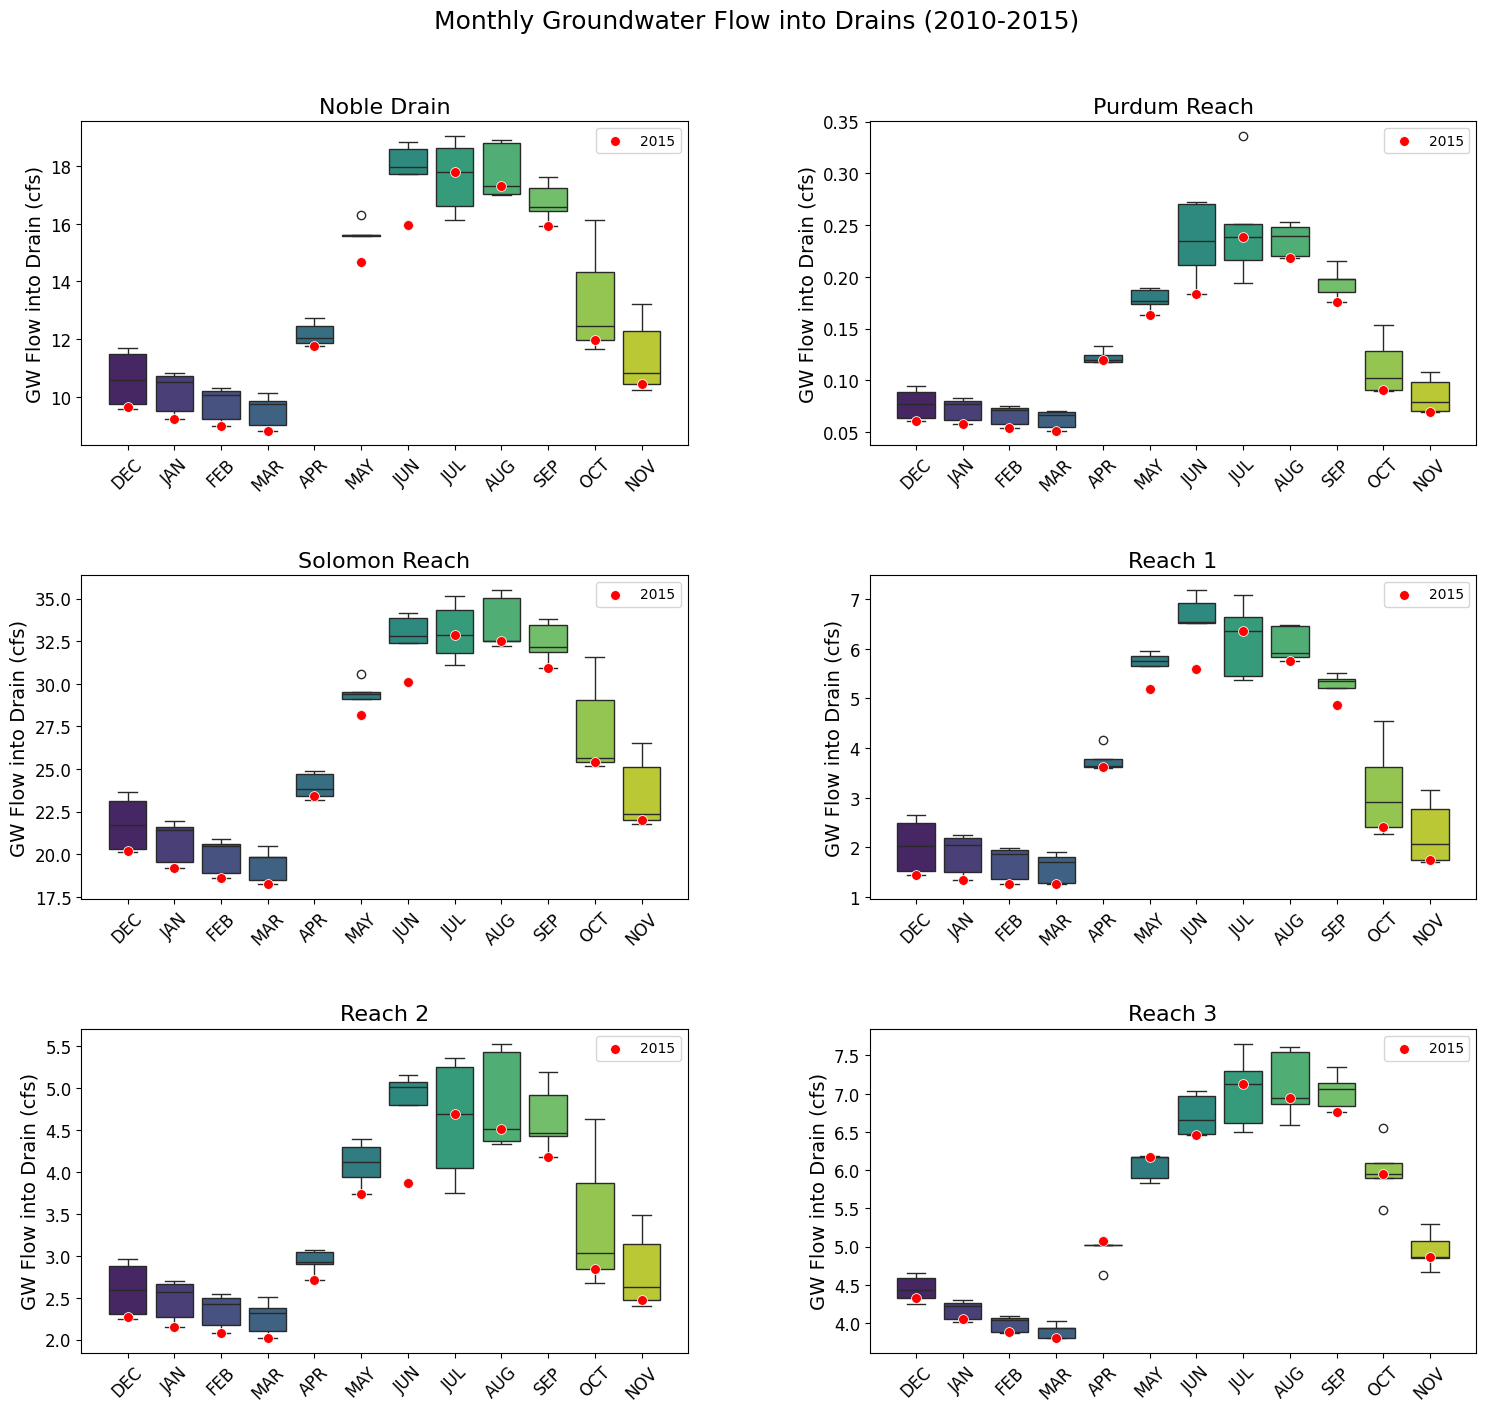

In [ ]:
# -------------------------------- #
# Figure: Boxplot of average gw to reach
# -------------------------------- #

# 2011 to 2015 data

# cfs

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/reach_gw_cfday.csv')

# Define the starting year and the total number of stress periods
start_year = 1986
total_stress_periods = 360

# Generate a sequence of dates starting from January of the starting year
dates = pd.date_range(start=f"{start_year}-01-01", periods=total_stress_periods, freq='MS')

# Create a new DataFrame mapping stress periods to months and years
dates_df = pd.DataFrame({
    'Stress Period': range(1, total_stress_periods + 1),
    'Month': dates.month,
    'Year': dates.year
})

# Merge the new date information into the original DataFrame
result_df = df.merge(dates_df, on='Stress Period')

# Convert numeric months to abbreviated names (e.g., 1 -> JAN, 12 -> DEC)
result_df['Month'] = result_df['Month'].apply(lambda x: calendar.month_abbr[x].upper())

# Convert Flow from cubic feet per day (cfperday) to cubic feet per second (cfs)
conversion_factor_cfs = 1 / (24 * 60 * 60)  # 1 day = 86400 seconds
result_df['Flow (cfs)'] = result_df['Flow (cfperday)'] * conversion_factor_cfs
result_df['Flow (Abs cfs)'] = result_df['Flow (cfs)'].abs()

# Filter data for the years 2010 to 2015
filtered_df = result_df[(result_df['Year'] >= 2010) & (result_df['Year'] <= 2015)]

# Get unique reaches
unique_reaches = filtered_df['Reach'].unique()

# Create a grid of subplots to display each reach in a larger layout (2 columns, 3 rows)
fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.3, hspace=0.4)  # Adjust grid size and spacing

# Loop through each reach and create a box plot for absolute flow in cfs
for idx, reach in enumerate(unique_reaches):
    ax = fig.add_subplot(gs[idx])  # Add subplot to the grid
    reach_data = filtered_df[filtered_df['Reach'] == reach]
    reach_data_2015 = reach_data[reach_data['Year'] == 2015]  # Filter data for 2015

    # Create the box plot
    sns.boxplot(
        data=reach_data,
        x='Month',
        y='Flow (Abs cfs)',
        palette='viridis',
        ax=ax
    )

    # Overlay 2015 data as red dots
    sns.scatterplot(
        data=reach_data_2015,
        x='Month',
        y='Flow (Abs cfs)',
        color='red',
        label='2015',
        s=50,  # Adjust size of the dots
        zorder=5,
        ax=ax
    )

    # Customize the plot
    ax.set_title(f'{reach}', fontsize=16)
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('GW Flow into Drain (cfs)', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# Add a common title for the entire figure
fig.suptitle('Monthly Groundwater Flow into Drains (2010-2015)', fontsize=18, y=0.95)

# Show the plot
plt.show()

## Extract TVGWFM Data for the entire study area ("allmason")

In [51]:
# ---------------------------- #
# GW contribution in all of Mason
# ---------------------------- #

# Output units: AF/day

# Function to compute groundwater contribution correctly by summing values within shapefile
def process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf):
    # Extract the masked array for the current stress period
    drn_ma_i = drn_out_arr[stress_period]
    drn_arr_i = drn_ma_i.filled(np.nan)
    drn_arr_lay1 = drn_arr_i[0, :, :]  # Top layer values

    # Grid dimensions
    nrows, ncols = drn_arr_lay1.shape
    cell_width = (max_lon - min_lon) / ncols
    cell_height = (max_lat - min_lat) / nrows

    # Create grid of polygons and values
    polygons = []
    values = []
    for i in range(nrows):
        for j in range(ncols):
            x1 = min_lon + j * cell_width
            y1 = max_lat - i * cell_height
            x2 = x1 + cell_width
            y2 = y1 - cell_height
            polygons.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
            # Convert cfs to acre-feet per month (30.4375 days per month)
            values.append(drn_arr_lay1[i, j] * 30.4375 / 43560)

    grid_gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values}, crs="EPSG:4326")
    if grid_gdf.crs != reach_gdf.crs:
        reach_gdf = reach_gdf.to_crs(grid_gdf.crs)
    total_groundwater_contribution = 0

    # Compute groundwater contribution per reach and sum it
    for _, reach in reach_gdf.iterrows():
        reach_geom = reach.geometry
        grid_gdf['intersection'] = grid_gdf.geometry.intersection(reach_geom)
        grid_gdf['intersected_value'] = grid_gdf['value'] * (grid_gdf['intersection'].area / grid_gdf.geometry.area)

        # Sum contributions within the reach
        reach_total = grid_gdf['intersected_value'].sum()
        total_groundwater_contribution += reach_total  # Sum across all reaches

    # Convert AF/month to AF/day
    total_groundwater_contribution_af_day = total_groundwater_contribution / 30.4375

    return {'Stress Period': stress_period, 'Total GW Contribution (AF/day)': total_groundwater_contribution_af_day}

# Define bounding box of Mason
min_lon, min_lat, max_lon, max_lat = -117.103530233726, 43.1778883119514, -115.768691366538, 44.1083


reach_gdf = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp') #reach shapefile
all_results = []

# Loop through stress periods
for stress_period in range(300, 361):
    result = process_stress_period(stress_period, drn_out_arr, min_lon, min_lat, max_lon, max_lat, reach_gdf)
    all_results.append(result)

results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/mason_gw_afperday.csv', index=False)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-51-590d28d33d16>:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersected_value'] = grid_gdf['value'] * (grid_gdf['intersection'].area / grid_gdf.geometry.area)
<ipython-input-51-590d28d33d16>:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['intersected_value'] = grid_gdf['value'] * (grid_gdf['intersection'].area / grid_gdf.geom

In [52]:
# --------------------------------------------- #
# Create Dataset for input into Total MAson WB
# ---------------------------------------------- #

# Output units: AF/month for each model simulation year & month

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/mason_gw_afperday.csv')

# Define the starting year and total number of stress periods
start_year = 1986
total_stress_periods = 360

# Generate a sequence of dates starting from January of the starting year
dates = pd.date_range(start=f"{start_year}-01-01", periods=total_stress_periods, freq='MS')
dates_df = pd.DataFrame({
    'Stress Period': range(1, total_stress_periods + 1),
    'Month': dates.month,
    'Year': dates.year
})


result_df = df.merge(dates_df, on='Stress Period')

result_df['Flow (KAF)'] = result_df['Total GW Contribution (AF/day)'] / 1000  # Convert Flow from AF/day to KAF

result_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/groundwater_out/mason_gw_final_kaf.csv', index=False)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
